In [11]:
import librosa
import soundfile as sf
import sounddevice as sd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Fonctions de traitement des signaux audio

Cette suite de fonctions est conçue pour les tâches de base du traitement des signaux audio, notamment la lecture, l'affichage, la transformation et l'analyse des fichiers audio.

## Aperçu des fonctions

- `read_mp3(file)` : Charge un fichier MP3 et renvoie le signal audio et la fréquence d'échantillonnage.
- `read_audio(file)` : Joue un fichier audio indéfiniment en utilisant la bibliothèque sounddevice.
- `apply_cqt(signal, sr)` : Applique la transformée Q constante à un signal audio et renvoie la transformée CQT.
- `print_cqt(cqt, sr)` : Affiche un spectrogramme de la TQC à des fins de visualisation.
- `calculate_fft(signal, sr)` : Calcule la transformée de Fourier rapide d'un signal audio.
- `filtrer_frequences(magnitudes, freq, fmax)` : Filtre les fréquences d'une transformée de Fourier rapide au-delà d'une fréquence maximale spécifiée.
- `print_spectrum(magnitudes, frequency)` : Visualise le spectre d'un signal audio basé sur sa FFT.
- `afficher_waveform(signal, sr)` : Affiche la forme d'onde d'un signal audio.

## Utilisation

Ces fonctions facilitent l'exploration et l'analyse des fichiers audio en fournissant des outils pour leur transformation et leur visualisation. Elles peuvent être utilisées pour des tâches telles que l'extraction de caractéristiques, l'analyse de signaux et la préparation de la classification audio.

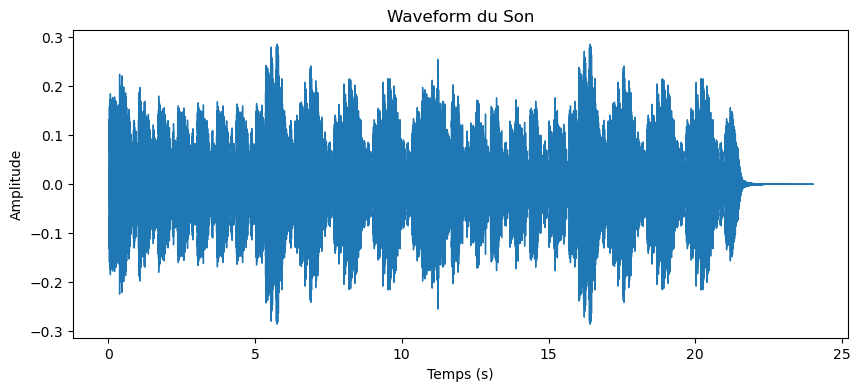

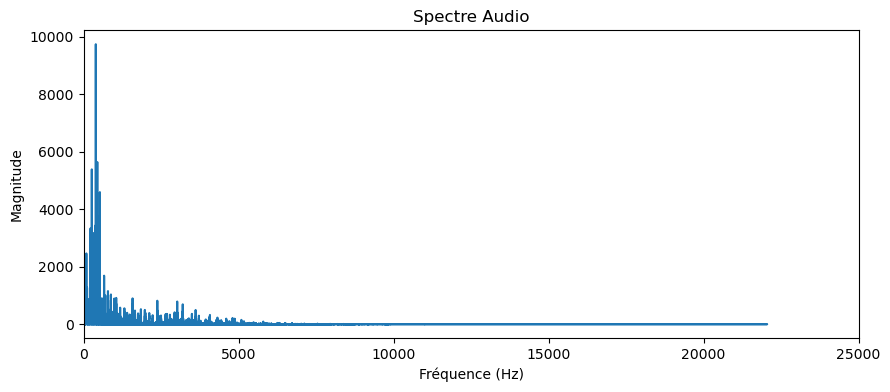

In [12]:
def read_mp3(file):
    signal, sr = librosa.load(file,sr=None)
    return signal,sr

def read_audio(file):
    signal,sr = sf.read(file)
    while True: 
        sd.play(signal,sr)
        sd.wait()

def apply_cqt(signal, sr):
    cqt = librosa.cqt(signal,sr=sr)
    return cqt

def print_cqt(cqt,sr):
    librosa.display.specshow(librosa.amplitude_to_db(cqt,ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Constant Q power spectrum')
    plt.tight_layout()
    plt.show()

def calculate_fft(signal,sr):
    fft = np.fft.fft(signal)
    magnitudes = np.abs(fft)
    frequency = np.fft.fftfreq(len(fft), 1/sr)
    return magnitudes, frequency

def filtrer_frequences(magnitudes, freq, fmax=25000):
    # On garde seulement les fréquences inférieures à fmax pour rester coherent fmax <= 25kHz
    indices = np.where(freq <= fmax)
    magnitudes_filtrées = magnitudes[indices]
    freq_filtrées = freq[indices]

    return magnitudes_filtrées, freq_filtrées



def print_spectrum(magnitudes,frequency):
    plt.figure(figsize=(10,4))
    plt.plot(frequency,magnitudes)
    plt.title('Spectre Audio')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, 25000)  # Limiter à 25 kHz
    plt.show()

def afficher_waveform(signal, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(signal, sr=sr)
    plt.title('Waveform du Son')
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.show()

########### PHASE TEST #####################################################################
#test sur un fichier -> on itere plus bas sur tout un dossier de fichiers mp3
file = "better-lost_91bpm_C_major.wav"
signal,sr = read_mp3(file)
afficher_waveform(signal, sr)
cqt = apply_cqt(signal,sr)
print_cqt(cqt,sr)


#read_audio(file)

magnitudes, frequency = calculate_fft(signal,sr)
magnitudes_filtrées, freq_filtrées = filtrer_frequences(magnitudes, frequency)
print_spectrum(magnitudes_filtrées,freq_filtrées)


############################################################################################


audio_folder = '../audio/'
audio_files = [os.path.join(audio_folder, file) for file in os.listdir(audio_folder) if file.endswith('.mp3')]

# Calcule des matrices CQT pour chaque fichier audio
cqt_matrices = []
for file in audio_files:
    signal, sr = read_mp3(file)
    cqt = apply_cqt(signal, sr)
    cqt_matrices.append(cqt)

Ces fonctions permettent de préparer les données CQT (Constant Q Transform) pour leur utilisation avec un Echo State Network (ESN). La transformation CQT est une méthode de traitement du signal audio qui fournit une représentation fréquentielle adaptée à l'analyse musicale.
- `Fonction normalize_cqt(cqt)` normalise les données CQT pour qu'elles soient dans l'intervalle [-1, 1]. La normalisation est réalisée en ajustant les valeurs de CQT en fonction de leurs valeurs minimales et maximales.

Paramètres :

    cqt : Matrice numpy représentant les données CQT d'un signal audio.

output :

    Matrice numpy des données CQT normalisées.

- `Fonction format_data_for_esn(cqt_data)` restructure les données CQT normalisées pour les adapter à l'entrée d'un ESN. Les données sont organisées sous forme d'un tableau numpy tridimensionnel où chaque élément représente une séquence temporelle de données CQT pour un fichier audio donné.

Paramètres :

    cqt_data : Liste de matrices numpy, chaque matrice représentant les données CQT normalisées d'un fichier audio.

output :

    Tableau numpy tridimensionnel contenant les données CQT formatées pour ESN.

In [15]:
def normalize_cqt(cqt):
    # Normalisisation des données CQT dans l'intervalle [-1, 1] (normalisation standard)
    min_val = np.min(cqt)
    max_val = np.max(cqt)
    cqt_normalized = 2 * (cqt - min_val) / (max_val - min_val) - 1
    return cqt_normalized

def format_data_for_esn(cqt_data):
    # Redimensionnement des données pour l'ESN en supposant que cqt_data est une liste de matrices CQT (une par fichier audio)
    formatted_data = np.array([normalize_cqt(cqt) for cqt in cqt_data])
    # Peut-etre redimensionner si nécessaire pour obtenir la forme (N, T, D) ? 
    return formatted_data

# Exemple d'utilisation
# (En supposant que cqt_matrices est une liste de matrices CQT
formatted_cqt_data = format_data_for_esn(cqt_matrices)


## Configuration et Utilisation de l'Echo State Network pour la Transcription Audio en MIDI

Dans cette partie du projet, on configure et utilise un Echo State Network (ESN) pour transcrire des données audio en format MIDI. Les étapes clés de cette section sont les suivantes :

### Paramètres du Réservoir

On définit d'abord les paramètres du réservoir, qui sont cruciaux pour le bon fonctionnement de l'ESN :

- `units` : Le nombre d'unités ou de neurones dans le réservoir. Ici, nous utilisons 500 unités.
- `leak_rate` : Le taux de fuite, qui contrôle la vitesse à laquelle l'état du réservoir se met à jour. Nous utilisons une valeur de 0.3.
- `spectral_radius` : Le rayon spectral de la matrice des poids du réservoir, fixé à 0.9.
- `input_scaling` : Le facteur d'échelle pour les données d'entrée, ici à 0.5.
- `connectivity` : La densité de connectivité des poids dans le réservoir, fixée à 0.1.

### Format des Données

On spécifie ensuite le format des données d'entrée et de sortie :

- `input_dim` : La dimension des données d'entrée, basée sur le nombre de fréquences dans la transformation CQT.
- `output_dim` : La dimension des données de sortie, c'est-à-dire le format des données MIDI.

### Création et Connexion du Réservoir et du Readout

Nous créons le réservoir et le readout (une couche de lecture) et les connectons :

- Le réservoir (`Reservoir`) est configuré avec les paramètres définis ci-dessus.
- Le readout (`Ridge`) est configuré pour faire correspondre les dimensions d'entrée et de sortie.

### Entraînement et Test de l'ESN

- Nous divisons les données en ensembles d'entraînement et de test.
- L'ESN est entraîné sur l'ensemble d'entraînement.
- Les performances de l'ESN sont évaluées sur l'ensemble de test, utilisant l'erreur quadratique moyenne (RMSE) comme métrique d'évaluation.



In [ ]:
from sklearn.metrics import mean_squared_error


#données midi pour entrainement
#midi_data =
# Paramètres du réservoir
units = 500
leak_rate = 0.3
spectral_radius = 0.9
input_scaling = 0.5
connectivity = 0.1

# Format des données d'entrée et de sortie
input_dim = cqt_matrices[0].shape[0]  # nombre de fréquences dans CQT
output_dim = midi_data[0].shape[1]    # format des données MIDI

# Création du réservoir et du readout
reservoir = Reservoir(units, input_dim=input_dim, lr=leak_rate, sr=spectral_radius, input_scaling=input_scaling, rc_connectivity=connectivity)
readout = Ridge(output_dim, input_dim=units)

# Connexion du réservoir au readout
esn = reservoir >> readout

# Préparation des ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(cqt_matrices, midi_data, test_size=0.2)

# Entraînement de l'ESN
esn.fit(X_train, Y_train)

# Test de l'ESN
predictions = esn.predict(X_test)

# Évaluation du modèle
rmse = mean_squared_error(Y_test, predictions, squared=False)
print("RMSE:", rmse)




Convertion des prédictions d'un modèle en un fichier MIDI utilisable,

In [ ]:
import pretty_midi
import numpy as np

def predictions_to_midi(predictions, sr, tempo=120):
    """
    Convertit les prédictions du modèle en fichier MIDI.

    :param predictions: Prédictions du modèle, supposées être une séquence de notes avec des attributs tels que la hauteur, le début, la fin et la vélocité.
    :param sr: Taux d'échantillonnage des données audio originales.
    :param tempo: Tempo du morceau en BPM (battements par minute).
    :return: Objet PrettyMIDI.
    """

    # Créer un objet PrettyMIDI
    midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)

    # Créer un instrument MIDI (ici un piano)
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program('Acoustic Grand Piano'))

    # Convertie chaque prédiction en une note MIDI
    for prediction in predictions:
        # Exemple de structure de 'prediction': [pitch, start_time, end_time, velocity]
        note = pretty_midi.Note(
            velocity=int(prediction[3]),
            pitch=int(prediction[0]),
            start=float(prediction[1]) / sr,
            end=float(prediction[2]) / sr
        )
        instrument.notes.append(note)

    # Ajoute l'instrument à l'objet PrettyMIDI
    midi.instruments.append(instrument)

    return midi

# Exemple d'utilisation
# 'predictions' devrait être une liste de prédictions où chaque prédiction contient des informations sur une note.
# Par exemple : [[60, 0, 0.5, 100], [62, 0.5, 1.0, 100], ...]
predictions = [...]  # A Remplacer par les predictions obtenues
sr = 22050  # A Remplacer par le taux d'échantillonnage des  données audio

# Convertie les prédictions en MIDI
midi = predictions_to_midi(predictions, sr)

# Sauvegardee le fichier MIDI
midi.write('output.mid')
